In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Configuration

In [2]:
SEQUENCE_SIZE = 64
BATCH_SIZE = 2048

# Data

In [3]:
dataset = load_household_power_consumption(hour_one_hot=True)
data_x, data_y = split_x_y(dataset)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x[:-SEQUENCE_SIZE], True, t=SEQUENCE_SIZE), 
    to_timeseries(data_y[SEQUENCE_SIZE:], t=SEQUENCE_SIZE), 
    train_ratio=0.8)

print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-22 21:00:06,586 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 31)
data_y: (43642, 1)
train_x: (34812, 64, 30)
train_y: (34812, 64, 1)
test_x: (8703, 64, 30)
test_y: (8703, 64, 1)


# Models

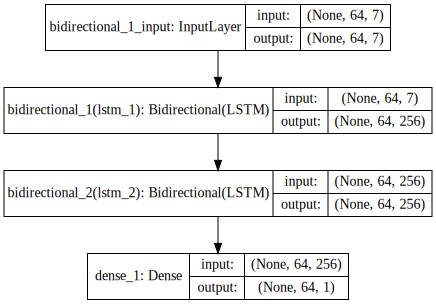

In [4]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64, n_input=7):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(LSTM(l1, return_sequences=True), input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Bidirectional(LSTM(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [5]:
model = create_model(l1=256, l2=256, n_input=30)

history = History()
model.fit(train_x, train_y, epochs=16, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34812 samples, validate on 8703 samples
Epoch 1/16
22s - loss: 0.0280 - acc: 2.6930e-06 - r2: -1.5950e+00 - val_loss: 0.0088 - val_acc: 1.1490e-04 - val_r2: -3.2781e-02
Epoch 2/16
20s - loss: 0.0087 - acc: 0.0000e+00 - r2: 0.1968 - val_loss: 0.0061 - val_acc: 1.1490e-04 - val_r2: 0.2736
Epoch 3/16
19s - loss: 0.0076 - acc: 0.0000e+00 - r2: 0.2902 - val_loss: 0.0057 - val_acc: 1.1490e-04 - val_r2: 0.2993
Epoch 4/16
20s - loss: 0.0074 - acc: 0.0000e+00 - r2: 0.3174 - val_loss: 0.0057 - val_acc: 1.1490e-04 - val_r2: 0.2955
Epoch 5/16
20s - loss: 0.0072 - acc: 0.0000e+00 - r2: 0.3358 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.2974
Epoch 6/16
19s - loss: 0.0070 - acc: 0.0000e+00 - r2: 0.3539 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.2894
Epoch 7/16
20s - loss: 0.0067 - acc: 0.0000e+00 - r2: 0.3739 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.3070
Epoch 8/16
20s - loss: 0.0065 - acc: 0.0000e+00 - r2: 0.3984 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_

# Evaluation

In [6]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 1.15 s, sys: 252 ms, total: 1.4 s
Wall time: 1.35 s
loss: 0.004778729831643842
acc: 0.0001149029070435482
r2: 0.4216562241887712


[275 ] r^2: -2.025      
[3348] r^2: -2.298      
[6629] r^2: -49.45      
[4352] r^2: 0.3952      
[1354] r^2: -1.627      
[188 ] r^2: 0.05186     
[2012] r^2: -3.197      
[3903] r^2: -1.621      
[5302] r^2: -3.544      
[4752] r^2: -0.2198     
[5008] r^2: 0.2449      
[7535] r^2: -8.494      
[6571] r^2: 0.1889      
[6422] r^2: 0.1221      
[8425] r^2: -3.037      
[3562] r^2: 0.572       


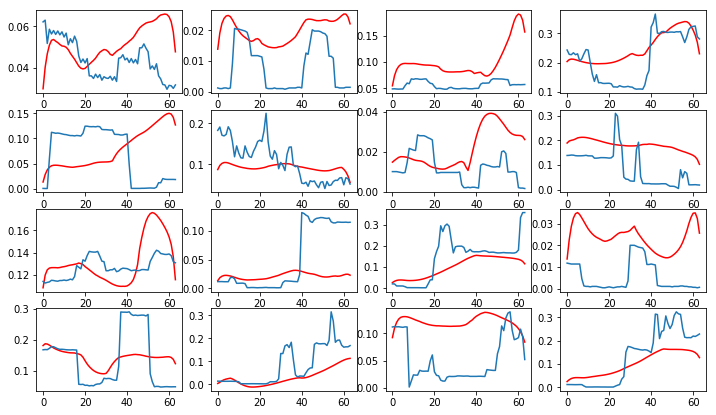

In [7]:
vis_evaluate(model, test_x, test_y, batch=2048)